In [192]:
import json
import os
import glob
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



class ExperimentLoader:
    def __init__(self, experiment_path):
        self.experiment_path = experiment_path
        self.config = None
        self.run_folders = []
        self.run_data_cache = {}

        self._load_config()
        self._find_run_folders()
        self._load_all_run_data()

    def _load_config(self):
        config_path = os.path.join(self.experiment_path, 'experiment.json')
        if not os.path.isfile(config_path):
            # Try finding any .json file if experiment.json doesn't exist
            json_files = glob.glob(os.path.join(
                self.experiment_path, '*.json'))
            if not json_files:
                print(
                    f"Warning: No JSON configuration file found in {self.experiment_path}")
                return  # Or raise an error if config is mandatory
            config_path = json_files[0]  # Load the first one found
            print(
                f"Warning: 'experiment.json' not found. Loading {os.path.basename(config_path)} instead.")

        try:
            with open(config_path, 'r') as f:
                self.config = json.load(f)
        except json.JSONDecodeError as e:
            raise ValueError(f"Error decoding JSON from {config_path}: {e}")
        except Exception as e:
            raise IOError(f"Error reading file {config_path}: {e}")

    def _find_run_folders(self):
        potential_runs = glob.glob(os.path.join(self.experiment_path, 'run_*'))
        self.run_folders = [
            run for run in potential_runs if os.path.isdir(run)]
        self.run_folders.sort()  # Sort them for consistency

    def _load_run_data(self, run_folder):
        if run_folder in self.run_data_cache:
            return self.run_data_cache[run_folder]

        file_path = os.path.join(run_folder, "run.json")
        if not os.path.exists(file_path):
            print(f"Warning: File not found {file_path}")
            self.run_data_cache[run_folder] = None
            return None
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                self.run_data_cache[run_folder] = data
                return data
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            self.run_data_cache[run_folder] = None
            return None

    def _load_all_run_data(self):
        for run_folder in self.run_folders:
            self._load_run_data(run_folder)  # Load and cache

    def get_all_best_rewards(self):
        all_best_rewards = []
        for run_folder in self.run_folders:
            data = self.run_data_cache.get(run_folder)
            if data:
                history = data.get("best_reward_history")
                if history and isinstance(history, list) and len(history) > 0:
                    # all_best_rewards.append(float(history[-1])) # Last element is the final best
                    all_best_rewards.append(max(history))

                else:
                    print(
                        f"Warning: 'best_reward_history' missing, empty, or invalid in {os.path.join(run_folder, 'run.json')}")
            # else: Warning already printed during loading

        return all_best_rewards

    def avg_best_reward_with_std(self):
        all_best_rewards = self.get_all_best_rewards()

        if not all_best_rewards:
            return np.nan, np.nan

        avg_reward = np.mean(all_best_rewards)
        # Use sample standard deviation (ddof=1)
        std_reward = np.std(all_best_rewards, ddof=1)
        return avg_reward, std_reward

    def get_all_best_fitness(self):
        all_best_fitness = []
        for run_folder in self.run_folders:
            data = self.run_data_cache.get(run_folder)
            if data:
                fitness = data.get("best_fitness")
                if fitness is not None:
                    all_best_fitness.append(float(fitness))
                else:
                    print(
                        f"Warning: 'best_fitness' missing or invalid in {os.path.join(run_folder, 'run.json')}")
            # else: Warning already printed during loading

        return all_best_fitness

    def avg_best_fitness_with_std(self):
        all_best_fitness = self.get_all_best_fitness()

        if not all_best_fitness:
            return np.nan, np.nan

        avg_fitness = np.mean(all_best_fitness)
        # Use sample standard deviation (ddof=1)
        std_fitness = np.std(all_best_fitness, ddof=1)
        return avg_fitness, std_fitness

    def avg_best_fitness_per_generation_with_std(self):

        all_runs_fitness_logs = []
        min_generations = float('inf')

        for run_folder in self.run_folders:
            data = self.run_data_cache.get(run_folder)
            if data:
                # Use best_fitness_history
                log_data = data.get("best_fitness_history")
                if log_data is not None and isinstance(log_data, list) and len(log_data) > 0:
                    all_runs_fitness_logs.append(np.array(log_data))
                    min_generations = min(min_generations, len(log_data))
                else:
                    print(
                        f"Warning: 'best_fitness_history' missing, empty or invalid in {os.path.join(run_folder, 'run.json')}")
            # else: Warning already printed during loading

        if not all_runs_fitness_logs or min_generations == float('inf'):
            return np.array([]), np.array([])

        # Trim logs to the minimum length found across runs
        trimmed_logs = [log[:min_generations] for log in all_runs_fitness_logs]

        # Stack logs into a 2D array (runs x generations)
        fitness_matrix = np.stack(trimmed_logs, axis=0)

        # Calculate mean and std dev across runs (axis=0) for each generation
        avg_fitness_per_gen = np.mean(fitness_matrix, axis=0)
        # Use sample standard deviation (ddof=1)
        std_fitness_per_gen = np.std(fitness_matrix, axis=0, ddof=1)

        return avg_fitness_per_gen, std_fitness_per_gen

    def avg_best_reward_per_generation_with_std(self):
        """
        Calculates the average and std dev of the best reward
        for each generation across all runs, using 'best_reward_history'.
        """
        all_runs_reward_logs = []
        min_generations = float('inf')

        for run_folder in self.run_folders:
            data = self.run_data_cache.get(run_folder)
            if data:
                # Use best_reward_history
                log_data = data.get("best_reward_history")
                if log_data is not None and isinstance(log_data, list) and len(log_data) > 0:
                    all_runs_reward_logs.append(np.array(log_data))
                    min_generations = min(min_generations, len(log_data))
                else:
                    print(
                        f"Warning: 'best_reward_history' missing, empty or invalid in {os.path.join(run_folder, 'run.json')}")
            # else: Warning already printed during loading

        if not all_runs_reward_logs or min_generations == float('inf'):
            return np.array([]), np.array([])

        # Trim logs
        trimmed_logs = [log[:min_generations] for log in all_runs_reward_logs]

        # Stack logs into a 2D array (runs x generations)
        reward_matrix = np.stack(trimmed_logs, axis=0)

        # Calculate mean and std dev across runs (axis=0) for each generation
        avg_reward_per_gen = np.mean(reward_matrix, axis=0)
        # Use sample standard deviation (ddof=1)
        std_reward_per_gen = np.std(reward_matrix, axis=0, ddof=1)

        return avg_reward_per_gen, std_reward_per_gen

In [193]:
def plot_reward_per_generation(algorithms, labels):
    """
    Plot the average and best reward per generation for each algorithm.
    """
    
    plt.figure(figsize=(10, 6))

    for algorithm, label in zip(algorithms, labels):
        avg_reward, std_reward = algorithm.avg_best_reward_per_generation_with_std()
        generations = np.arange(len(avg_reward))

        # Plot average reward with error bars
        plt.plot(generations, avg_reward, label=label)
        plt.fill_between(generations, avg_reward - std_reward,
                         avg_reward + std_reward, alpha=0.2)

    plt.title("Average Best Reward per Generation")
    plt.xlabel("Generation")
    plt.ylabel("Best Reward")
    plt.legend()
    plt.grid()
    plt.show()

        

In [194]:

#Task 1 - Walker-v0
ea_alt_gait = ExperimentLoader("results/task1/Walker-v0/EA_alt_gait_controller_Test_D12_M04_23_02")
ea_hopping = ExperimentLoader("results/task1/Walker-v0/EA_hopping_controller_Test_D12_M04_23_31")
ea_sinusoidal = ExperimentLoader("results/task1/Walker-v0/EA_sinusoidal_controller_Test_D12_M04_16_48")

random_search = ExperimentLoader("results/task1/Walker-v0/(0)RandomSearch_D20_M04_11_26")
ea_swapmut_1pcross = ExperimentLoader("results/task1/Walker-v0/(1.1)GeneticAl_SwapMut_1PCross_D19_M04_10_20")
ea_swapmut_unifcross = ExperimentLoader("results/task1/Walker-v0/(1.2)GeneticAl_SwapMut_UnifCross_D19_M04_17_46")
ea_flipmut_1pcross = ExperimentLoader("results/task1/Walker-v0/(1.3)GeneticAl_FlipMut_1PCross_D19_M04_23_45")
ea_flipmut_unifcross = ExperimentLoader("results/task1/Walker-v0/(1.4)GeneticAl_FlipMut_UnifCross_D19_M04_23_27")

ea_flipmut_1pcross_010 = ExperimentLoader("results/task1/Walker-v0/(1.3M010)GeneticAl_FlipMut_1PCross_D20_M04_19_55")
ea_flipmut_1pcross_015 = ExperimentLoader("results/task1/Walker-v0/(1.3M015)GeneticAl_FlipMut_1PCross_D20_M04_13_49")

ea_flipmut_unifcross_T2 = ExperimentLoader("results/task1/Walker-v0/(1.3M015T2)GeneticAl_FlipMut_1PCross_D21_M04_22_40")
ea_flipmut_unifcross_T6 = ExperimentLoader("results/task1/Walker-v0/(1.3M015T6)GeneticAl_FlipMut_1PCross_D21_M04_11_15")

ea_flipmut_unifcross_E1 = ExperimentLoader("results/task1/Walker-v0/(1.3M015E1)GeneticAl_FlipMut_1PCross_D21_M04_14_48")

#Task 1 - BridgeWalker-v0

random_search_bridge = ExperimentLoader("results/task1/BridgeWalker-v0/(0)RandomSearch_D23_M04_14_01")
ea_flipmut_unifcross_bridge = ExperimentLoader("results/task1/BridgeWalker-v0/(1.2)GeneticAl_FlipMut_UnifCross_D24_M04_00_45")
ea_flipmut_1pcross_bridge = ExperimentLoader("results/task1/BridgeWalker-v0/(1.1)GeneticAl_FlipMut_1PCross_D22_M04_23_46")

# Task 2 - DownStepper-v0

random_search_downstepper = ExperimentLoader("results/task2/DownStepper-v0/(0)Random_Search_D29_M04_16_51")
mu_plus_lambda = ExperimentLoader("results/task2/DownStepper-v0/(1)mupluslambda_D03_M05_12_26")
DE_best = ExperimentLoader("results/task2/DownStepper-v0/(2.2)DeBest1Bin_D30_M04_10_17")
DE_rand = ExperimentLoader("results/task2/DownStepper-v0/(2.1)DeRand1Bin_D29_M04_19_59")
CMA_ES = ExperimentLoader("results/task2/DownStepper-v0/(3)CMA-ES_D04_M05_12_23")
best_GA = ExperimentLoader("results/task2/DownStepper-v0/(task1)BestGATask1_D01_M05_20_59")


In [195]:
#Statistical Tests definitions

def kruskal_wallis(data):
    """
    non parametric
    many samples
    independent
    """     
    H,pval = st.kruskal(*data)
    return (H,pval)

def mann_whitney(data1,data2):
    """
    non parametric
    two samples
    independent
    """    
    return st.mannwhitneyu(data1, data2, alternative='two-sided')


def pairwise_mann_whitney_with_bonferroni(data_groups, labels):
    """
    pairwise Mann-Whitney U tests with Bonferroni correction
    """
    import itertools
    import numpy as np
    import pandas as pd
    
    # Generate all pairs of group indices
    pairs = list(itertools.combinations(range(len(data_groups)), 2))
    p_vals = []
    
    # Compute p-values for all pairs
    for i, j in pairs:
        _, p = st.mannwhitneyu(data_groups[i], data_groups[j], alternative='two-sided')
        p_vals.append(p)
    
    # Bonferroni correction (multiply by number of tests, max 1.0)
    m = len(p_vals)
    p_adj = [min(p * m, 1.0) for p in p_vals]
    
    # Build a symmetric matrix of adjusted p-values
    p_mat = np.ones((len(data_groups), len(data_groups)))
    for (i, j), padj in zip(pairs, p_adj):
        p_mat[i, j] = p_mat[j, i] = padj
    
    # Create a DataFrame for better display
    p_df = pd.DataFrame(p_mat, index=labels, columns=labels)
    
    return p_df

In [196]:
# --- Load final best rewards ---
# in this case rewards were the same as fitness

#Task 1 - Walker-v0

alt_rewards = ea_alt_gait.get_all_best_rewards()
hopping_rewards = ea_hopping.get_all_best_rewards()
sinusoidal_rewards = ea_sinusoidal.get_all_best_rewards()

random_rewards = random_search.get_all_best_rewards()
ea_swapmut_1pcross_rewards = ea_swapmut_1pcross.get_all_best_rewards()
ea_swapmut_unifcross_rewards = ea_swapmut_unifcross.get_all_best_rewards()
ea_flipmut_1pcross_rewards = ea_flipmut_1pcross.get_all_best_rewards()
ea_flipmut_unifcross_rewards = ea_flipmut_unifcross.get_all_best_rewards()

ea_flipmut_1pcross_010_rewards = ea_flipmut_1pcross_010.get_all_best_rewards()
ea_flipmut_1pcross_015_rewards = ea_flipmut_1pcross_015.get_all_best_rewards()

ea_flipmut_unifcross_T2_rewards = ea_flipmut_unifcross_T2.get_all_best_rewards()
ea_flipmut_unifcross_T6_rewards = ea_flipmut_unifcross_T6.get_all_best_rewards()

ea_flipmut_unifcross_E1_rewards = ea_flipmut_unifcross_E1.get_all_best_rewards()

#Task 1 - BridgeWalker-v0
random_rewards_bridge = random_search_bridge.get_all_best_rewards()
ea_flipmut_unifcross_bridge_rewards = ea_flipmut_unifcross_bridge.get_all_best_rewards()
ea_flipmut_1pcross_bridge_rewards = ea_flipmut_1pcross_bridge.get_all_best_rewards()

#Task 2 - DownStepper-v0
random_rewards_downstepper = random_search_downstepper.get_all_best_rewards()
mu_plus_lambda_rewards = mu_plus_lambda.get_all_best_rewards()
DE_best_rewards = DE_best.get_all_best_rewards()
DE_rand_rewards = DE_rand.get_all_best_rewards()
CMA_ES_rewards = CMA_ES.get_all_best_rewards()
best_GA_rewards = best_GA.get_all_best_rewards()

# Change here for new comparison

labels = ["random_downstepper", "mu_plus_lambda", "DE_best", "DE_rand", "CMA_ES", "best_GA"]
reward_data = [ random_rewards_downstepper, mu_plus_lambda_rewards, DE_best_rewards, DE_rand_rewards, CMA_ES_rewards, best_GA_rewards] 



## Pre-Task 1: Pick controller to evolve


In [197]:
ea_alt_gait = ExperimentLoader("results/task1/Walker-v0/EA_alt_gait_controller_Test_D12_M04_23_02")
ea_hopping = ExperimentLoader("results/task1/Walker-v0/EA_hopping_controller_Test_D12_M04_23_31")
ea_sinusoidal = ExperimentLoader("results/task1/Walker-v0/EA_sinusoidal_controller_Test_D12_M04_16_48")

algorithms = [ea_alt_gait, ea_hopping, ea_sinusoidal]
labels = ["AltGait", "Hopping", "Sinusoidal"]

In [198]:
H, pval = kruskal_wallis([alg.get_all_best_rewards() for alg in algorithms])
print(f"Kruskal-Wallis H-statistic: {H}, p-value: {pval}")

Kruskal-Wallis H-statistic: 9.5, p-value: 0.008651695203120634


In [199]:
p_mw_controller = pairwise_mann_whitney_with_bonferroni([alg.get_all_best_rewards() for alg in algorithms], labels)
print("Pairwise Mann-Whitney U test with Bonferroni correction:\n", p_mw_controller)

Pairwise Mann-Whitney U test with Bonferroni correction:
             AltGait  Hopping  Sinusoidal
AltGait     1.00000  1.00000     0.02381
Hopping     1.00000  1.00000     0.02381
Sinusoidal  0.02381  0.02381     1.00000


C:\Users\josem\AppData\Local\Temp\ipykernel_23304\3032949918.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([alg.get_all_best_rewards() for alg in algorithms], labels=labels)


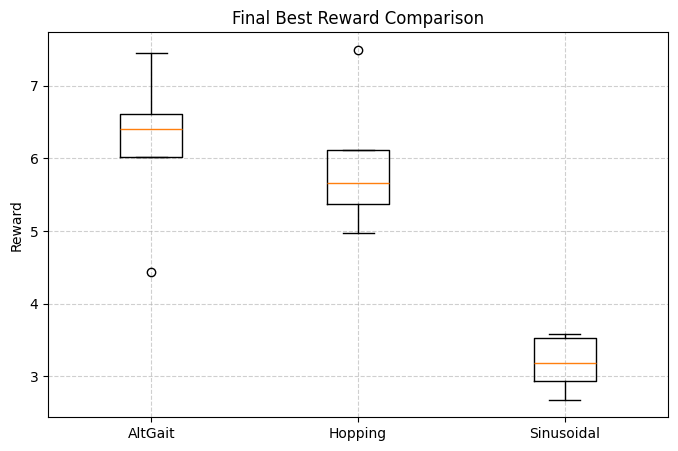

In [200]:
plt.figure(figsize=(8, 5))
plt.boxplot([alg.get_all_best_rewards() for alg in algorithms], labels=labels)
plt.title("Final Best Reward Comparison")
plt.ylabel("Reward")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [201]:
# --- Kruskal-Wallis Test ---
H, p_kw = kruskal_wallis(reward_data)
print("\n Kruskal-Wallis Test:")
print(f"H-statistic = {H:.3f}, p-value = {p_kw:.5f}")

# --- Mann-Whitney Pairwise Comparisons ---


pairs = [("random_downstepper", random_rewards_downstepper, "mu_plus_lambda", mu_plus_lambda_rewards),
        ("random_downstepper", random_rewards_downstepper, "DE_best", DE_best_rewards),
        ("random_downstepper", random_rewards_downstepper, "DE_rand", DE_rand_rewards),
        ("random_downstepper", random_rewards_downstepper, "CMA_ES", CMA_ES_rewards),
        ("random_downstepper", random_rewards_downstepper, "best_GA", best_GA_rewards),

        ("mu_plus_lambda", mu_plus_lambda_rewards, "DE_best", DE_best_rewards),
        ("mu_plus_lambda", mu_plus_lambda_rewards, "DE_rand", DE_rand_rewards),
        ("mu_plus_lambda", mu_plus_lambda_rewards, "CMA_ES", CMA_ES_rewards),
        ("mu_plus_lambda", mu_plus_lambda_rewards, "best_GA", best_GA_rewards),

        ("DE_best", DE_best_rewards, "DE_rand", DE_rand_rewards),
        ("DE_best", DE_best_rewards, "CMA_ES", CMA_ES_rewards),
        ("DE_best", DE_best_rewards, "best_GA", best_GA_rewards),

        ("DE_rand", DE_rand_rewards, "CMA_ES", CMA_ES_rewards),
        ("DE_rand", DE_rand_rewards, "best_GA", best_GA_rewards),

        ("CMA_ES", CMA_ES_rewards, "best_GA", best_GA_rewards)
    ]

alpha = 0.05
corrected_alpha = alpha / len(pairs)

print(f"\n Mann-Whitney U Tests (Bonferroni corrected α = {corrected_alpha:.5f}):")
for name1, data1, name2, data2 in pairs:
    U, p = mann_whitney(data1, data2)
    n1, n2 = len(data1), len(data2)
    # Effect size
    n = n1 + n2
    mean_U = n1 * n2 / 2
    std_U = np.sqrt(n1 * n2 * (n + 1) / 12)
    z = (U - mean_U) / std_U
    r = z / np.sqrt(n)

    significance = " Significant" if p < corrected_alpha else " Not significant"
    print(f"{name1} vs {name2} -> p = {p:.5f}, effect size r = {r:.3f} → {significance}")



 Kruskal-Wallis Test:
H-statistic = 11.906, p-value = 0.03610

 Mann-Whitney U Tests (Bonferroni corrected α = 0.00333):
random_downstepper vs mu_plus_lambda -> p = 0.54762, effect size r = -0.231 →  Not significant
random_downstepper vs DE_best -> p = 0.01587, effect size r = -0.760 →  Not significant
random_downstepper vs DE_rand -> p = 0.01587, effect size r = -0.760 →  Not significant
random_downstepper vs CMA_ES -> p = 0.03175, effect size r = -0.694 →  Not significant
random_downstepper vs best_GA -> p = 0.05556, effect size r = -0.628 →  Not significant
mu_plus_lambda vs DE_best -> p = 0.30952, effect size r = -0.363 →  Not significant
mu_plus_lambda vs DE_rand -> p = 0.22222, effect size r = -0.429 →  Not significant
mu_plus_lambda vs CMA_ES -> p = 0.30952, effect size r = -0.363 →  Not significant
mu_plus_lambda vs best_GA -> p = 0.15079, effect size r = -0.495 →  Not significant
DE_best vs DE_rand -> p = 0.30952, effect size r = -0.363 →  Not significant
DE_best vs CMA_ES ->


 Summary (Median ± Std):
AltGait: 2.25 ± 0.36
Hopping: 2.54 ± 1.12
Sinusoidal: 3.11 ± 0.39


C:\Users\josem\AppData\Local\Temp\ipykernel_23304\3667405106.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(reward_data, labels=labels)


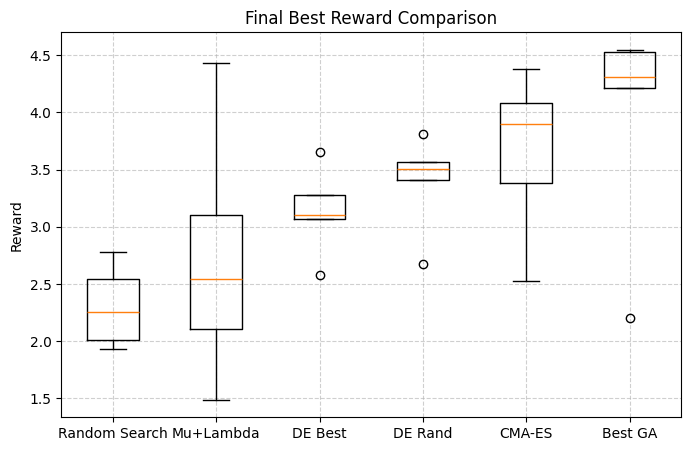

In [202]:
# --- Summary Statistics ---
print("\n Summary (Median ± Std):")
for name, data in zip(labels, reward_data):
    print(f"{name}: {np.median(data):.2f} ± {np.std(data, ddof=1):.2f}")
    
labels = ["Random Search", "Mu+Lambda", "DE Best", "DE Rand", "CMA-ES", "Best GA"]

# --- Optional: Boxplot for visual comparison ---
plt.figure(figsize=(8, 5))
plt.boxplot(reward_data, labels=labels)
plt.title("Final Best Reward Comparison")
plt.ylabel("Reward")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Task 2

### Comparison 1: Which is the best algorithm for evolving the controller of a fixed structure?

Load data from experiments

In [203]:
bestGATask1 = ExperimentLoader("results/task2/DownStepper-v0/(task1)BestGATask1_D01_M05_20_59")
deRand1Bin = ExperimentLoader("results/task2/DownStepper-v0/(2.1)DeRand1Bin_D29_M04_19_59")
deBest1Bin = ExperimentLoader("results/task2/DownStepper-v0/(2.2)DeBest1Bin_D30_M04_10_17")
cmaES = ExperimentLoader("results/task2/DownStepper-v0/(3)CMA-ES_D04_M05_12_23")
randomSearch = ExperimentLoader("results/task2/DownStepper-v0/(0)Random_Search_D29_M04_16_51")
muPlusLambda = ExperimentLoader("results/task2/DownStepper-v0/(1)mupluslambda_D03_M05_12_26")

In [204]:
algorithms = [bestGATask1, deRand1Bin, deBest1Bin, cmaES, randomSearch, muPlusLambda]

for alg in algorithms:
    print(f"Algorithm: {alg.experiment_path.split('/')[-1]}")
    avg_fitness, std_fitness = alg.avg_best_fitness_with_std()
    print(f"Average Best Fitness: {avg_fitness:.2f} ± {std_fitness:.2f}")
    avg_reward, std_reward = alg.avg_best_reward_with_std()
    print(f"Average Best Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    print("-" * 50)

Algorithm: (task1)BestGATask1_D01_M05_20_59
Average Best Fitness: 3.96 ± 0.99
Average Best Reward: 3.96 ± 0.99
--------------------------------------------------
Algorithm: (2.1)DeRand1Bin_D29_M04_19_59
Average Best Fitness: 3.39 ± 0.43
Average Best Reward: 3.39 ± 0.43
--------------------------------------------------
Algorithm: (2.2)DeBest1Bin_D30_M04_10_17
Average Best Fitness: 3.14 ± 0.39
Average Best Reward: 3.14 ± 0.39
--------------------------------------------------
Algorithm: (3)CMA-ES_D04_M05_12_23
Average Best Fitness: 3.65 ± 0.73
Average Best Reward: 3.65 ± 0.73
--------------------------------------------------
Algorithm: (0)Random_Search_D29_M04_16_51
Average Best Fitness: 2.30 ± 0.36
Average Best Reward: 2.30 ± 0.36
--------------------------------------------------
Algorithm: (1)mupluslambda_D03_M05_12_26
Average Best Fitness: 2.73 ± 1.12
Average Best Reward: 2.73 ± 1.12
--------------------------------------------------


In [205]:
groups = [
    bestGATask1.get_all_best_rewards(),
    deRand1Bin.get_all_best_rewards(),
    deBest1Bin.get_all_best_rewards(),
    cmaES.get_all_best_rewards(),
    randomSearch.get_all_best_rewards(),
    muPlusLambda.get_all_best_rewards()
]

Run the kruskal wallis test

In [206]:
kruskal_wallis_result = kruskal_wallis(groups)

print(f"Kruskal-Wallis Test: H-statistic = {kruskal_wallis_result[0]:.3f}, p-value = {kruskal_wallis_result[1]:.5f}")

Kruskal-Wallis Test: H-statistic = 11.906, p-value = 0.03610


Run pairwise Mann whitney tests

In [207]:
p_mw=pairwise_mann_whitney_with_bonferroni(groups, ["bestGATask1", "deRand1Bin", "deBest1Bin", "cmaES", "randomSearch", "muPlusLambda"])

print("\nPairwise Mann-Whitney U Tests with Bonferroni correction:")
print(p_mw)
        


Pairwise Mann-Whitney U Tests with Bonferroni correction:
              bestGATask1  deRand1Bin  deBest1Bin    cmaES  randomSearch  \
bestGATask1      1.000000    1.000000    1.000000  1.00000      0.833333   
deRand1Bin       1.000000    1.000000    1.000000  1.00000      0.238095   
deBest1Bin       1.000000    1.000000    1.000000  1.00000      0.238095   
cmaES            1.000000    1.000000    1.000000  1.00000      0.476190   
randomSearch     0.833333    0.238095    0.238095  0.47619      1.000000   
muPlusLambda     1.000000    1.000000    1.000000  1.00000      1.000000   

              muPlusLambda  
bestGATask1            1.0  
deRand1Bin             1.0  
deBest1Bin             1.0  
cmaES                  1.0  
randomSearch           1.0  
muPlusLambda           1.0  


Boxplot

C:\Users\josem\AppData\Local\Temp\ipykernel_23304\2447458662.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=["Best GA", "DE Rand", "DE Best", "CMA-ES", "Random Search", "Mu+Lambda"])


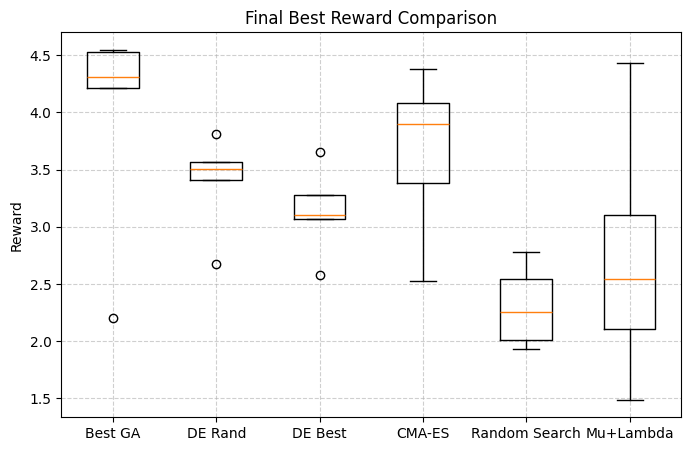

In [215]:
# --- Optional: Boxplot for visual comparison ---
plt.figure(figsize=(8, 5))
plt.boxplot(groups, labels=["Best GA", "DE Rand", "DE Best", "CMA-ES", "Random Search", "Mu+Lambda"])
plt.title("Final Best Reward Comparison")
plt.ylabel("Reward")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

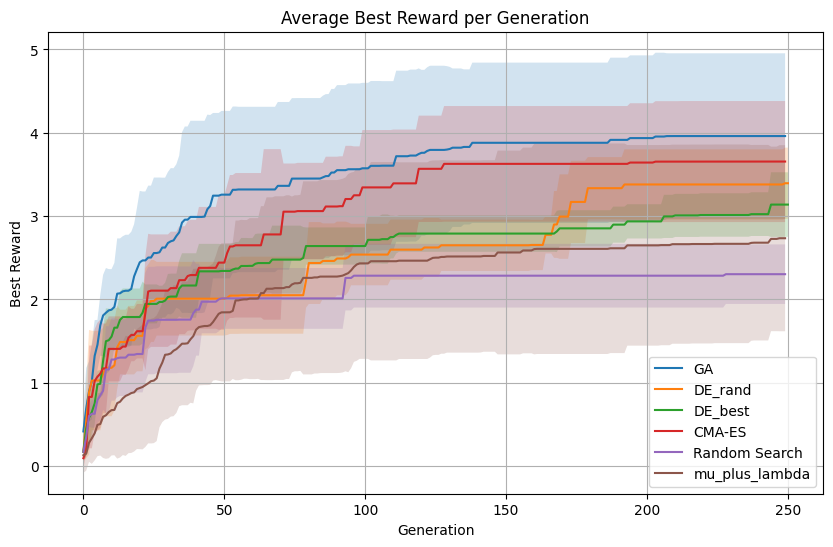

In [214]:
plot_reward_per_generation(algorithms, ["GA", "DE_rand", "DE_best", "CMA-ES", "Random Search", "mu_plus_lambda"])

### Comparison 2: Doubling the budget(250->500 gens), which is the best algorithm?

In [209]:
GA500 = ExperimentLoader("results/task2/DownStepper-v0/(500)(task1)BestGATask1_D04_M05_23_00")
DE500 = ExperimentLoader("results/task2/DownStepper-v0/(500)(2.1)DeRand1Bin_D05_M05_11_33")
CMAES500 = ExperimentLoader("results/task2/DownStepper-v0/(500)(3)CMA-ES_D05_M05_00_01")

In [210]:
groups500 = [
    GA500.get_all_best_rewards(),
    DE500.get_all_best_rewards(),
    CMAES500.get_all_best_rewards()
]

labels = ["GA500", "DE500", "CMAES500"]

Kruskal Wallis test

In [211]:
kruskal_wallis_result_500 = kruskal_wallis(groups500)
print(f"Kruskal-Wallis Test (500): H-statistic = {kruskal_wallis_result_500[0]:.3f}, p-value = {kruskal_wallis_result_500[1]:.5f}")

Kruskal-Wallis Test (500): H-statistic = 2.880, p-value = 0.23693
